In [1]:
import sys
from pathlib import Path
import pandas as pd
import logging


PROJECT_ROOT = Path.cwd().resolve().parent 
sys.path.append(str(PROJECT_ROOT))

from src.rag_prep import EmbeddingProcessor

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


c:\Users\amare\Documents\KAIM\week-7\rag-complaint-chatbot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

CLEANED_CSV_PATH = PROJECT_ROOT / "data" /"processed"/ "filtered_complaints.csv"
VECTOR_STORE_DIR =  PROJECT_ROOT /"vector_store"


In [3]:
df = pd.read_csv(CLEANED_CSV_PATH)
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID',
       'processed_feedback', 'normalized_feedback'],
      dtype='object')

In [4]:
processor = EmbeddingProcessor(
    cleaned_csv_path=CLEANED_CSV_PATH,
    vector_store_dir=VECTOR_STORE_DIR,
    sample_size=15000,           # default sample size
    chunk_size=500,              # default chunk size
    chunk_overlap=50,            # default overlap
    embedding_model_name="sentence-transformers/all-MiniLM-L6-v2",
    random_state=42
)

2026-01-04 14:25:32,834 [INFO] Use pytorch device_name: cpu
2026-01-04 14:25:32,837 [INFO] Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2026-01-04 14:25:46,519 [INFO] Loaded embedding model: sentence-transformers/all-MiniLM-L6-v2
2026-01-04 14:25:46,519 [INFO] EmbeddingProcessor initialized


In [5]:
processor.run_pipeline()


2026-01-04 14:26:24,979 [INFO] Loaded cleaned dataset with 454,472 rows
2026-01-04 14:26:25,728 [INFO] Stratified sample contains 14,349 rows across 7 categories


C:\Users\amare\Documents\KAIM\week-7\rag-complaint-chatbot\src\rag_prep.py:101: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), per_category), random_state=self.random_state))
Chunking Text: 100%|██████████| 14349/14349 [00:08<00:00, 1652.82it/s]

2026-01-04 14:26:34,449 [INFO] Total chunks created: 46,161



Embedding Chunks: 100%|██████████| 91/91 [54:06<00:00, 35.68s/it]   

2026-01-04 15:20:41,152 [INFO] Generated embeddings with shape: (46161, 384)
2026-01-04 15:20:41,207 [INFO] FAISS index created with 46161 vectors


2026-01-04 15:20:41,399 [INFO] FAISS index and metadata saved in C:\Users\amare\Documents\KAIM\week-7\rag-complaint-chatbot\vector_store
2026-01-04 15:20:41,401 [INFO] Task 2 pipeline completed successfully


In [6]:
logger.info(f"Sampled complaints: {len(processor.sample_df):,}")
logger.info(f"Total text chunks: {len(processor.chunks):,}")
logger.info(f"Embeddings shape: {processor.embeddings.shape}")
logger.info(f"FAISS index vectors: {processor.index.ntotal}")
logger.info(f"Vector store saved in: {VECTOR_STORE_DIR}")

2026-01-04 15:20:49,758 [INFO] Sampled complaints: 14,349
2026-01-04 15:20:49,758 [INFO] Total text chunks: 46,161
2026-01-04 15:20:49,758 [INFO] Embeddings shape: (46161, 384)
2026-01-04 15:20:49,766 [INFO] FAISS index vectors: 46161
2026-01-04 15:20:49,769 [INFO] Vector store saved in: C:\Users\amare\Documents\KAIM\week-7\rag-complaint-chatbot\vector_store


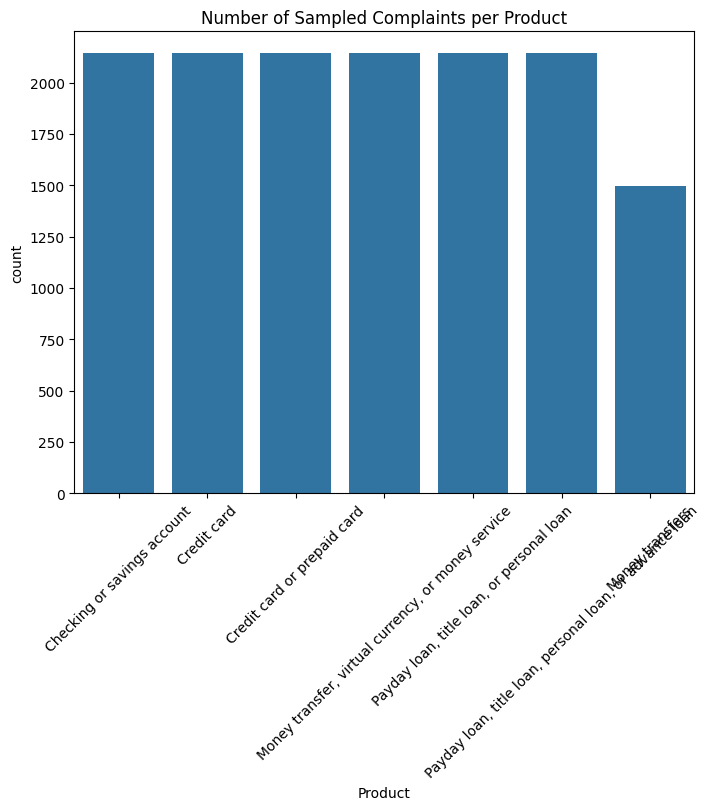

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"

# Make sure the folder exists
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Create the plot
plt.figure(figsize=(8, 6))
sns.countplot(
    data=processor.sample_df,
    x="Product",
    order=processor.sample_df["Product"].value_counts().index
)
plt.xticks(rotation=45)
plt.title("Number of Sampled Complaints per Product")

# Save the figure
file_path = FIGURES_DIR / "sampled_complaints_per_product.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)

# Optional: display the plot
plt.show()


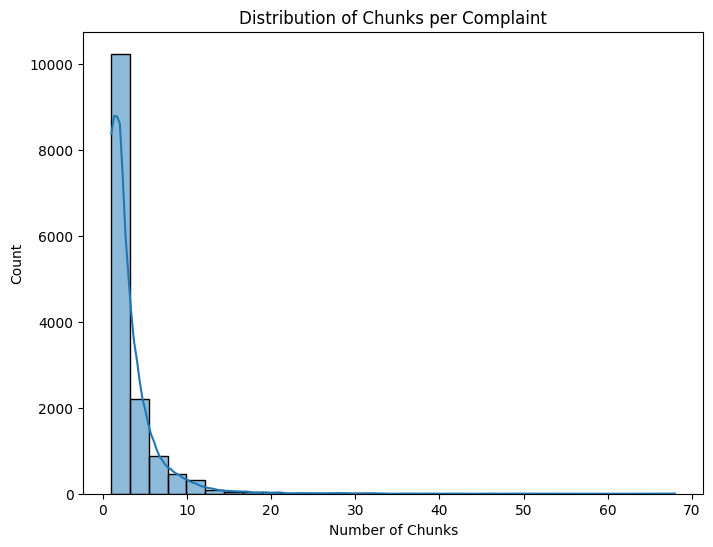

In [13]:
import pandas as pd

chunks_df = pd.DataFrame(processor.metadata)
chunks_per_complaint = chunks_df.groupby("complaint_id")["chunk_index"].count()

# Create the plot
plt.figure(figsize=(8, 6))
sns.histplot(chunks_per_complaint, bins=30, kde=True)
plt.title("Distribution of Chunks per Complaint")
plt.xlabel("Number of Chunks")

# Save the figure
file_path = FIGURES_DIR / "chunks_per_complaint_distribution.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)

# Optional: display the plot
plt.show()


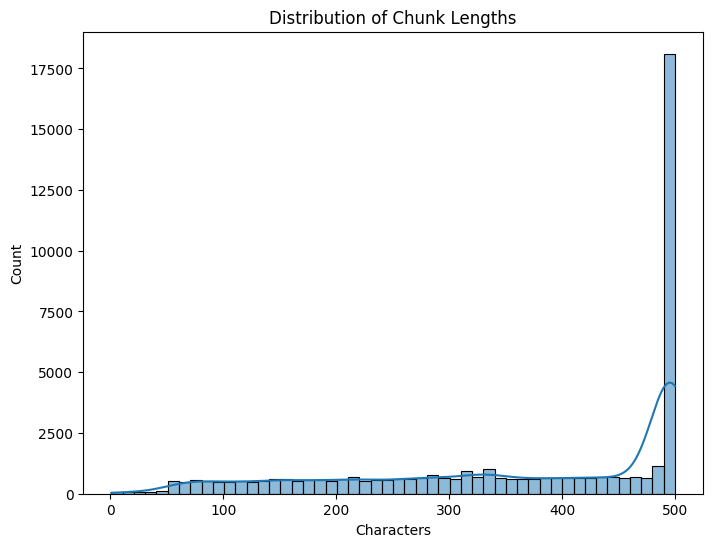

In [14]:
chunk_lengths = [len(c) for c in processor.chunks]

plt.figure(figsize=(8, 6))
sns.histplot(chunk_lengths, bins=50, kde=True)
plt.title("Distribution of Chunk Lengths")
plt.xlabel("Characters")

# Save the figure
file_path = FIGURES_DIR / "chunk_lengths_distribution.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)

# Optional: display the plot
plt.show()


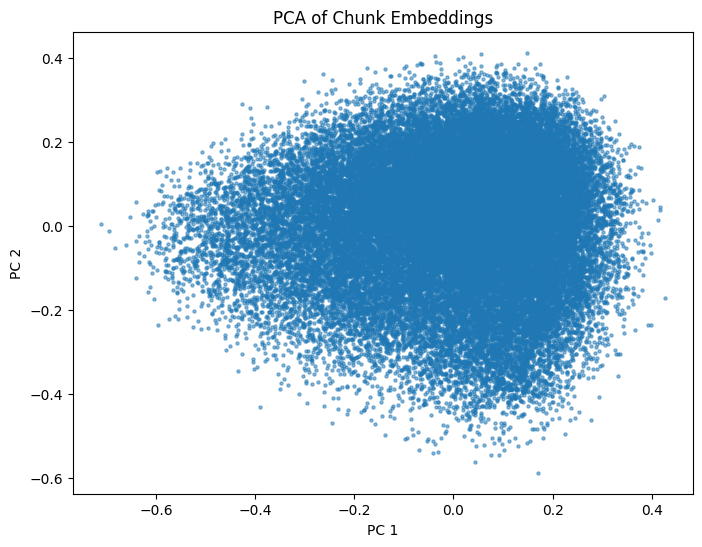

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(processor.embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5, s=5)
plt.title("PCA of Chunk Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Save the figure
file_path = FIGURES_DIR / "pca_chunk_embeddings.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)

# Optional: display the plot
plt.show()


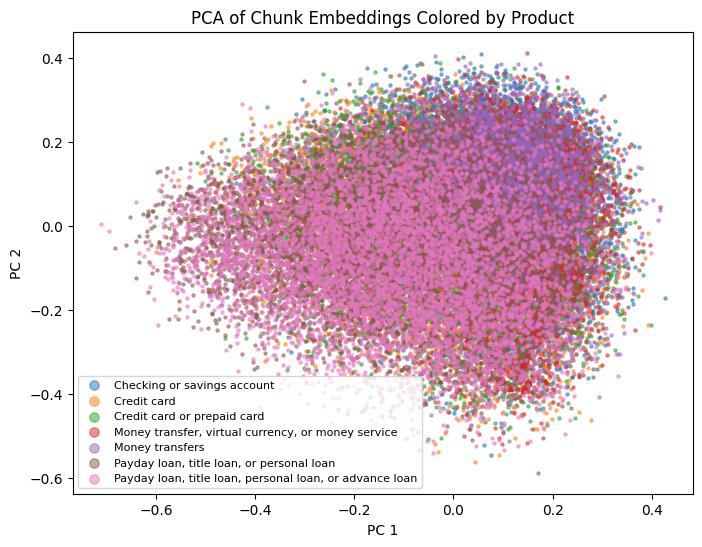

In [16]:
product_labels = chunks_df['product'].values

plt.figure(figsize=(8, 6))
for product in chunks_df['product'].unique():
    idx = chunks_df['product'] == product
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=product, s=5, alpha=0.5)
plt.legend(markerscale=3, fontsize=8)  # make legend markers bigger for visibility
plt.title("PCA of Chunk Embeddings Colored by Product")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Save the figure
file_path = FIGURES_DIR / "pca_chunk_embeddings_by_product.png"
plt.savefig(file_path, bbox_inches='tight', dpi=300)

# Optional: display the plot
plt.show()
